<a href="https://colab.research.google.com/github/sandeepexe/RAG/blob/main/rag1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For RAG


RAG stands for Retrieval Augmented Generation.

It was introduced in the paper  [*Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*](https://arxiv.org/abs/2005.11401).

Each step can be roughly broken down to:

Retrieval - Seeking relevant information from a source given a query. For example, getting relevant passages of Wikipedia text from a database given a question.
Augmented - Using the relevant retrieved information to modify an input to a generative model (e.g. an LLM).
Generation - Generating an output given an input. For example, in the case of an LLM, generating a passage of text given an input prompt.



this colab notebook contains course ( deep learning ai rag ) notebook contents with slight explanation alongside.

In [16]:
#import lib
!pip install -q sentence-transformers

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm
from sentence_transformers import SentenceTransformer # Now you can import it

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 80.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
#we use mnist numbers dataset
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
#Normalize and Reshape images (flatten) to lessen the data values
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

11490434/11490434 [==============================] - 0s 0us/step


next we print the difference of original and flattened data

In [3]:
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


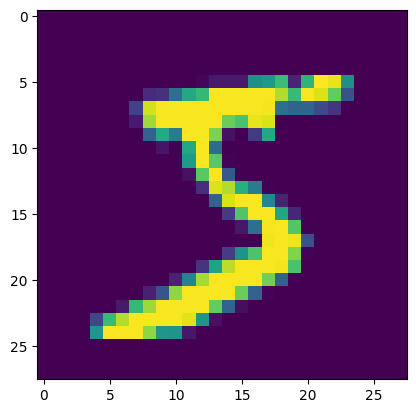

In [6]:
# Example of a training image
plt.imshow(x_tr[0]);

In [5]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

from here we are constructing VAE - Variational Autoencoders

In [7]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps
  # Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)


reconstruction input/ data loss calculation and model building here

In [8]:
# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

below this code you can see the loss getting reduced after each epoch, this is telling us that after every epoch the model is getting better than the previous.

In [9]:
# train
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1
)

Epoch 1/50
600/600 [==============================] - 6s 8ms/step - loss: 204.0963 - val_loss: 182.6253
Epoch 2/50
600/600 [==============================] - 5s 9ms/step - loss: 175.5011 - val_loss: 167.8153
Epoch 3/50
600/600 [==============================] - 5s 9ms/step - loss: 164.4358 - val_loss: 160.5995
Epoch 4/50
600/600 [==============================] - 6s 10ms/step - loss: 159.3121 - val_loss: 157.5815
Epoch 5/50
600/600 [==============================] - 5s 8ms/step - loss: 156.4216 - val_loss: 155.1622
Epoch 6/50
600/600 [==============================] - 6s 10ms/step - loss: 154.2352 - val_loss: 152.6120
Epoch 7/50
600/600 [==============================] - 5s 9ms/step - loss: 151.9416 - val_loss: 150.7711
Epoch 8/50
600/600 [==============================] - 5s 9ms/step - loss: 150.0204 - val_loss: 149.5267
Epoch 9/50
600/600 [==============================] - 6s 10ms/step - loss: 148.2287 - val_loss: 147.7367
Epoch 10/50
600/600 [==============================] - 5s 9ms

KeyboardInterrupt: 

In [10]:
#building encoder
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder

visualising embeddings here

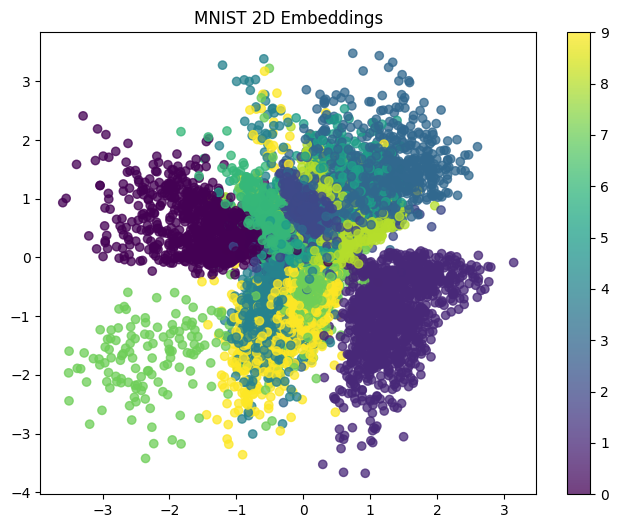

In [11]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

an example of text embeddings here - (not related to above)

In [17]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the park views',
            'The national park had great views',
            'olive oil is tasty']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

below we can see first 2 sentences are kind of similar so their embeddings are also somehwat similar but not of the third one.

In [18]:
#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

[[ 0.67128694  0.1515332  -0.18801677 ...  0.36637098 -0.49236137
   0.08232355]
 [ 0.669333    0.4009498  -0.48208404 ...  0.10645862 -1.506716
  -0.01547342]
 [ 0.08007105 -0.45527825 -0.11557627 ...  0.09837117  0.66695976
   0.27131104]]
